# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read i data
df = pd.read_csv('airline.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(413, 7)
(413, 7)


In [3]:
df.head()

,id,title,text,username,language,rating,ratingtext
0,1,Lost my baggage provided no compensation Awful...,PIAC lost my baggage on January 2 2020 on PK78...,arcticantipodean,en,1,Very Bad
1,2,Another worse flight experience PK6754 Date of...,I was very happy when I planned my vacation an...,abdulhaseeb346,en,1,Very Bad
2,3,Thieves,This is the worst airline in the world It took...,368minas,en,1,Very Bad
3,4,Bad service,One of the worst customer service I heard a cr...,Sean7861,en,1,Very Bad
4,5,Worst airline ever,Dangerous flight asked for blanket was told th...,hamzal468,en,1,Very Bad


## Quick EDA

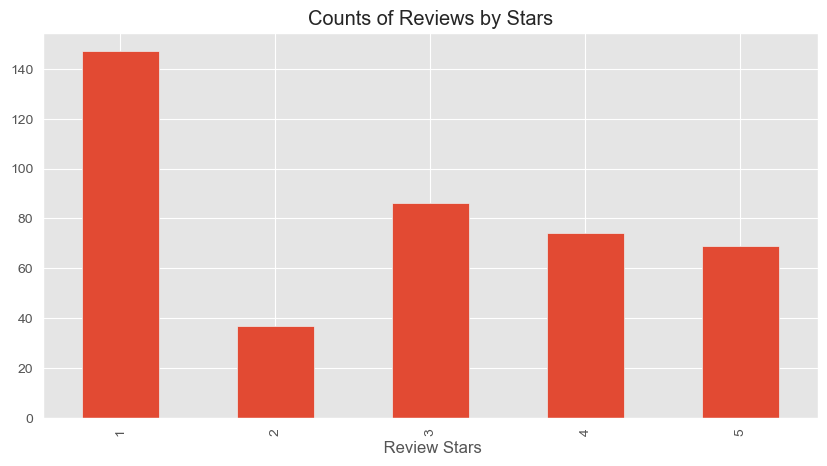

In [4]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Counts of Reviews by Stars', 
          figsize= (10, 5))
ax.set_xlabel(' Review Stars')
plt.show()

## Basic NLTK

In [5]:
example = df['text'][7]
print(example)

Reasonable fare good in flight service landing and take off on time Provides direct trips to most destinations is a best part Pakistan Zindabad


In [6]:
tokens = nltk.word_tokenize(example)
tokens [:10]

['Reasonable',
 'fare',
 'good',
 'in',
 'flight',
 'service',
 'landing',
 'and',
 'take',
 'off']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Reasonable', 'JJ'),
 ('fare', 'NN'),
 ('good', 'JJ'),
 ('in', 'IN'),
 ('flight', 'NN'),
 ('service', 'NN'),
 ('landing', 'NN'),
 ('and', 'CC'),
 ('take', 'VB'),
 ('off', 'RP')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Reasonable/JJ)
  fare/NN
  good/JJ
  in/IN
  flight/NN
  service/NN
  landing/NN
  and/CC
  take/VB
  off/RP
  on/IN
  time/NN
  Provides/NNP
  direct/JJ
  trips/NNS
  to/TO
  most/JJS
  destinations/NNS
  is/VBZ
  a/DT
  best/JJS
  part/NN
  (GPE Pakistan/NNP)
  Zindabad/NNP)


In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# Step 3. Roberta Pretrained Model

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [11]:
import torch

In [12]:
print(torch.__version__)

2.0.0


In [13]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [14]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Reasonable fare good in flight service landing and take off on time Provides direct trips to most destinations is a best part Pakistan Zindabad


{'neg': 0.0, 'neu': 0.74, 'pos': 0.26, 'compound': 0.8107}

In [15]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0027805888, 'roberta_neu': 0.06566195, 'roberta_pos': 0.9315575}


In [16]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Reberta_neg' : scores[0],
        'Reberta_neu' : scores[1],
        'Reberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except (RuntimeError, IndexError):
        print(f'Broke for ID {myid}')

  0%|          | 0/413 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for ID 36


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'id'})
results_df = results_df.merge(df, how='left')

# Compare Scores between models

In [ ]:
results_df.columns

In [ ]:
sns.pairplot(data=results_df, 
             vars=['Reberta_neg', 'Reberta_neu','Reberta_pos'],
            hue='rating',
            palette='tab10')


# Step 4: Review Examples:

In [ ]:
# positive sentiment 1 star review
results_df.query('rating == 1') \
    .sort_values('Reberta_pos', ascending=False)['text'].values[0]

In [ ]:
# negative sentiment 5 star review
results_df.query('rating == 5') \
    .sort_values('Reberta_neg', ascending=False)['text'].values[0]

# Extra: The Transfomers Pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")